In [131]:
import numpy as np
import matplotlib.pyplot as plt

In [132]:
# Time setup
total_years = 20
dt = 1/10  # yearly time step
time = np.arange(0, total_years, dt)
n = len(time)


# Initialize arrays

Below_Baseline_Stock = np.zeros(n)
Baseline_Stock = np.zeros(n)
Efficient_Stock = np.zeros(n)
Cumulative_adopters = np.zeros(n)


Retirement_Flow_arr = np.zeros(n)
Below_Baseline_Adoption_Flow_arr = np.zeros(n)
Baseline_Adoption_Flow_arr = np.zeros(n)
Efficient_Adoption_Flow_arr = np.zeros(n)
Total_Adoption_Flow_arr = np.zeros(n)
bass_share_arr = np.zeros(n)
bass_value_arr = np.zeros(n)



In [133]:

""" Could do this from individual pieces to total market size or market size to individual pieces"""
m = 1000  # market size for the equipment # not used in Par
# Initial stocks
initial_below_baseline = m * 0.3  # 30% below baseline
initial_baseline = m * 0.5  # 50% baseline
initial_efficient = m* 0.2  # 20% efficient at start

retirement_rate = 0.05    # 5% of total equipment retires per year

initial_adopters = initial_efficient  # Initial adopters are those with efficient equipment
#total_stock = initial_below_baseline + initial_baseline + initial_efficient
# Set initial values

Below_Baseline_Stock[0] = initial_below_baseline
Baseline_Stock[0] = initial_baseline
Efficient_Stock[0] = initial_efficient
Cumulative_adopters[0] = initial_adopters

In [134]:
# Bass diffusion and retirement parameters
par = {
    "p": 0.05,                 # innovation coefficient
    "q": 0.5,                 # imitation coefficient
}


In [ ]:
# thsi cell is bass Defission for each iteration with total population being the retired

def bass_diff_eq(Below_Baseline, Baseline, Efficient, Cumulative_adopters, par, m, retirement_rate):
    p = par["p"]
    q = par["q"]

    
    bass_value = (p + q * (Cumulative_adopters / m)) * (m - Cumulative_adopters)
    #Number of upgrades occurring in the current time step.
    #if we want a discrete version
    # innovation*(marketsize - penetration_start) + imitation*(1/marketsize)*penetration_start*(marketsize-penetration_start)
    #bass_value = (p + q * (Cumulative_adopters / m)) * (1 - Cumulative_adopters / m)
    bass_share = np.clip((bass_value + Cumulative_adopters)/m, 0.0, 1.0)

# adjusting for retirement 
    Retirement_Flow = m * retirement_rate
    Efficient_Adoption_Flow = Retirement_Flow * bass_share #(1-bass_share)
    Remaining_Flow = Retirement_Flow - Efficient_Adoption_Flow

    Baseline_Adoption_Flow = Remaining_Flow
    Below_Baseline_Adoption_Flow = 0.0

    # Euler differentials
    dEfficient_dt = Efficient_Adoption_Flow - (Efficient * retirement_rate)
    dBaseline_dt = Baseline_Adoption_Flow - (Baseline * retirement_rate)
    dBelow_Baseline_dt = Below_Baseline_Adoption_Flow - (Below_Baseline * retirement_rate)
    dadopters_dt = Efficient_Adoption_Flow #- (Efficient * retirement_rate)

    flows = {
        "Retirement": Retirement_Flow,
        "Efficient_Adoption": Efficient_Adoption_Flow,
        "Baseline_Adoption": Baseline_Adoption_Flow,
        "Below_Baseline_Adoption": Below_Baseline_Adoption_Flow,
        "Total_Adoption_Flow": Retirement_Flow,
        "bass_value": bass_value,
        "bass_share": bass_share,
        "Cumulative_adopters": Cumulative_adopters
    }

    return dBelow_Baseline_dt, dBaseline_dt, dEfficient_dt, dadopters_dt, flows



In [136]:
for t in range(1, n):
    dBelow_Baseline_dt, dBaseline_dt, dEfficient_dt, dadopters_dt,  flows = bass_diff_eq(
        Below_Baseline_Stock[t-1],
        Baseline_Stock[t-1],
        Efficient_Stock[t-1],
        Cumulative_adopters[t-1],
        par,
        m, 
        retirement_rate
    )

    # Euler integration
    Below_Baseline_Stock[t] = Below_Baseline_Stock[t-1] + dBelow_Baseline_dt * dt
    Baseline_Stock[t] = Baseline_Stock[t-1] + dBaseline_dt * dt
    Efficient_Stock[t] = Efficient_Stock[t-1] + dEfficient_dt * dt
    Cumulative_adopters[t] = Cumulative_adopters[t-1] + dadopters_dt * dt

#enforce non-negitivity
    Below_Baseline_Stock[t] = max(Below_Baseline_Stock[t], 0.0)
    Baseline_Stock[t]       = max(Baseline_Stock[t], 0.0)
    Efficient_Stock[t]      = max(Efficient_Stock[t], 0.0)
    Cumulative_adopters[t]  = max(Cumulative_adopters[t], 0.0)

    # Log flows
    Retirement_Flow_arr[t] = flows["Retirement"]
    Efficient_Adoption_Flow_arr[t] = flows["Efficient_Adoption"]
    Baseline_Adoption_Flow_arr[t] = flows["Baseline_Adoption"]
    Below_Baseline_Adoption_Flow_arr[t] = flows["Below_Baseline_Adoption"]
    Total_Adoption_Flow_arr[t] = flows["Total_Adoption_Flow"]
    bass_share_arr[t] = flows["bass_share"]
    bass_value_arr[t] = flows["bass_value"]
    #Cumulative_adopters[t] = flows["Cumulative_adopters"]

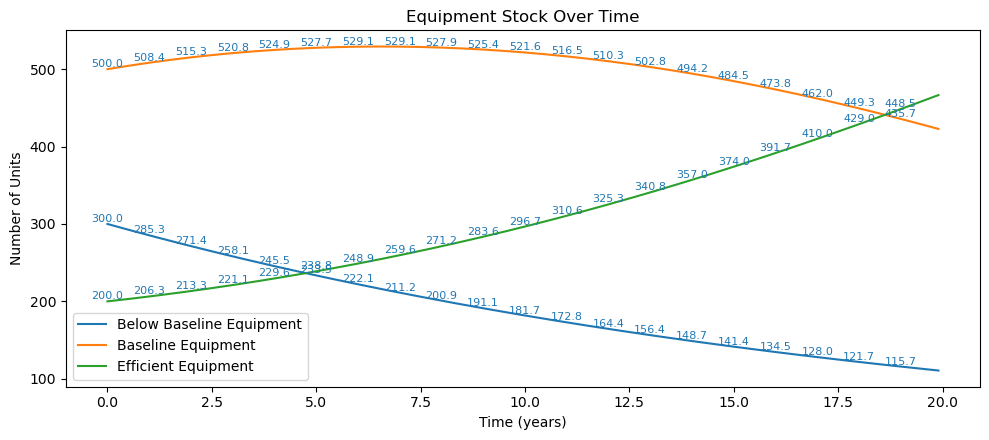

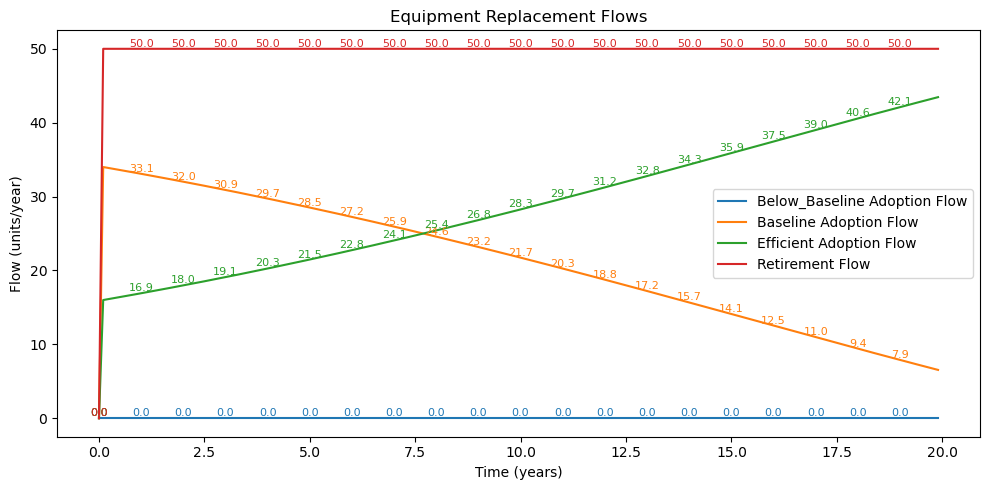

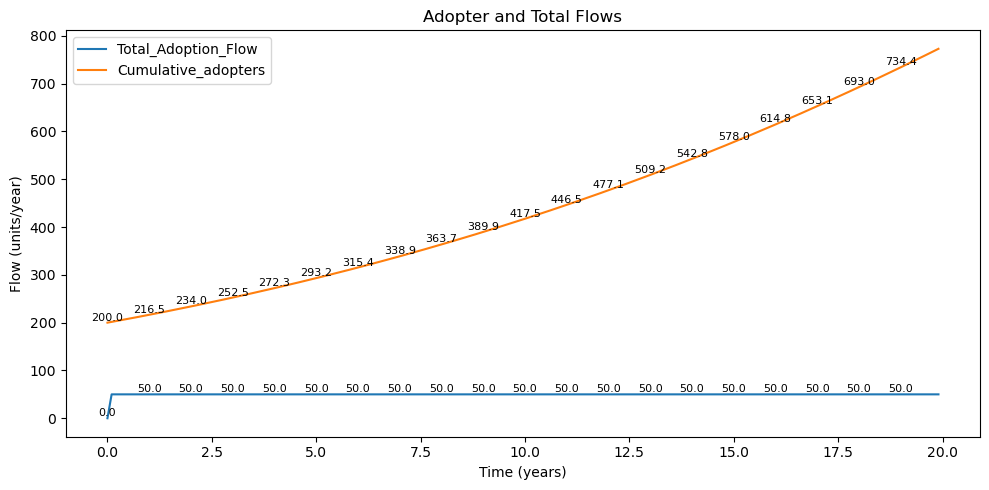

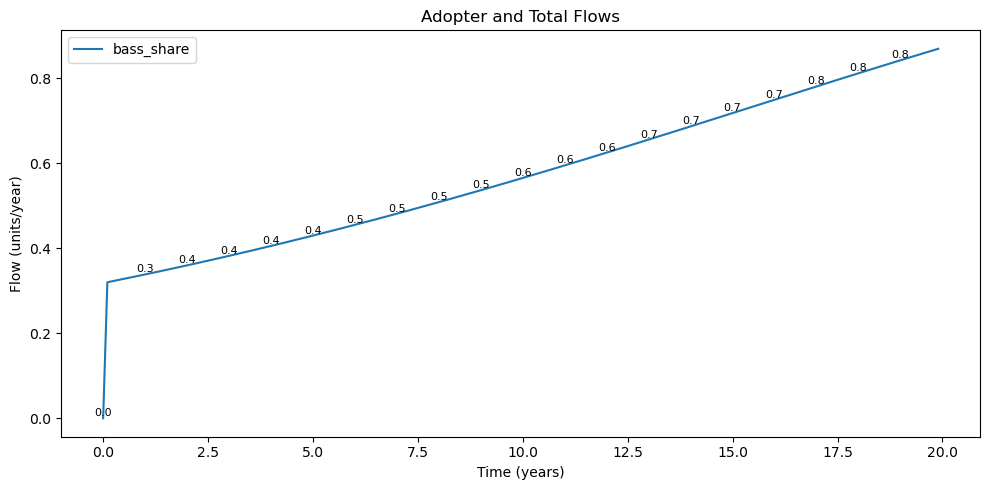

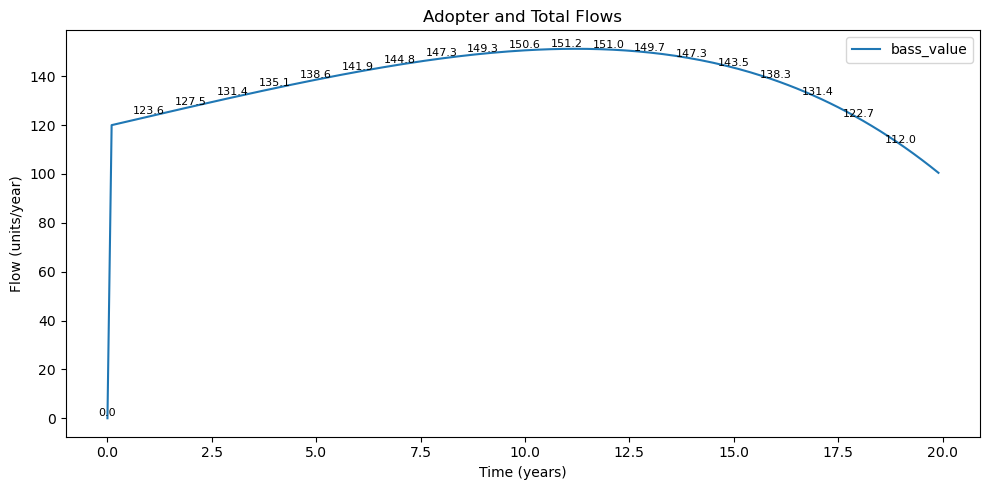

In [137]:
# Equipment Stocks
plt.figure(figsize=(10, 4.5))
plt.plot(time, Below_Baseline_Stock, label="Below Baseline Equipment")
plt.plot(time, Baseline_Stock, label="Baseline Equipment")
plt.plot(time, Efficient_Stock, label="Efficient Equipment")
for i in range(0, len(time), 10):
    plt.text(time[i], Efficient_Stock[i], f"{Efficient_Stock[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], Baseline_Stock[i], f"{Baseline_Stock[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], Below_Baseline_Stock[i], f"{Below_Baseline_Stock[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
plt.xlabel("Time (years)")
plt.ylabel("Number of Units")
plt.title("Equipment Stock Over Time")
plt.legend()
plt.tight_layout()
plt.show()

# Equipment Flows
plt.figure(figsize=(10, 5))
plt.plot(time, Below_Baseline_Adoption_Flow_arr, label="Below_Baseline Adoption Flow")
plt.plot(time, Baseline_Adoption_Flow_arr, label="Baseline Adoption Flow")
plt.plot(time, Efficient_Adoption_Flow_arr, label="Efficient Adoption Flow")
plt.plot(time, Retirement_Flow_arr, label="Retirement Flow")

for i in range(0, len(time), 10):
    plt.text(time[i], Below_Baseline_Adoption_Flow_arr[i], f"{Below_Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:blue')
    plt.text(time[i], Baseline_Adoption_Flow_arr[i], f"{Baseline_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:orange')
    plt.text(time[i], Efficient_Adoption_Flow_arr[i], f"{Efficient_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:green')
    plt.text(time[i], Retirement_Flow_arr[i], f"{Retirement_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom', color='tab:red')

plt.xlabel("Time (years)")
plt.ylabel("Flow (units/year)")
plt.title("Equipment Replacement Flows")
plt.legend()
plt.tight_layout()
plt.show()

# Adopters
plt.figure(figsize=(10, 5))
plt.plot(time, Total_Adoption_Flow_arr, label="Total_Adoption_Flow")
# Add Y-value labels every 10th point
for i in range(0, len(time), 10):
    plt.text(time[i], Total_Adoption_Flow_arr[i], f"{Total_Adoption_Flow_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom')
plt.plot(time, Cumulative_adopters, label="Cumulative_adopters")
# Add Y-value labels every 10th point
for i in range(0, len(time), 10):
    plt.text(time[i], Cumulative_adopters[i], f"{Cumulative_adopters[i]:.1f}", 
             fontsize=8, ha='center', va='bottom')
plt.xlabel("Time (years)")
plt.ylabel("Flow (units/year)")
plt.title("Adopter and Total Flows")
plt.legend()
plt.tight_layout()
plt.show()

#Bass Flow
# Adopters
plt.figure(figsize=(10, 5))
plt.plot(time, bass_share_arr, label="bass_share")

# Add Y-value labels every 10th point
for i in range(0, len(time), 10):
    plt.text(time[i], bass_share_arr[i], f"{bass_share_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom')
plt.xlabel("Time (years)")
plt.ylabel("Flow (units/year)")
plt.title("Adopter and Total Flows")
plt.legend()
plt.tight_layout()
plt.show()

#Bass values
# Adopters
plt.figure(figsize=(10, 5))
plt.plot(time, bass_value_arr, label="bass_value")

# Add Y-value labels every 10th point
for i in range(0, len(time), 10):
    plt.text(time[i], bass_value_arr[i], f"{bass_value_arr[i]:.1f}", 
             fontsize=8, ha='center', va='bottom')
plt.xlabel("Time (years)")
plt.ylabel("Flow (units/year)")
plt.title("Adopter and Total Flows")
plt.legend()
plt.tight_layout()
plt.show()

In [138]:
Cumulative_adopters

array([200.        , 201.6       , 203.2099936 , 204.8300303 ,
       206.46015967, 208.10043133, 209.75089498, 211.41160038,
       213.08259732, 214.76393567, 216.45566533, 218.15783626,
       219.87049847, 221.593702  , 223.32749692, 225.07193334,
       226.82706142, 228.59293133, 230.36959326, 232.15709743,
       233.9554941 , 235.76483349, 237.5851659 , 239.41654157,
       241.2590108 , 243.11262385, 244.977431  , 246.85348252,
       248.74082867, 250.63951967, 252.54960577, 254.47113715,
       256.404164  , 258.34873645, 260.30490461, 262.27271856,
       264.25222833, 266.24348388, 268.24653516, 270.26143203,
       272.28822431, 274.32696174, 276.37769401, 278.44047072,
       280.51534139, 282.60235547, 284.70156232, 286.8130112 ,
       288.93675127, 291.0728316 , 293.22130115, 295.38220875,
       297.55560314, 299.74153292, 301.94004657, 304.15119243,
       306.37501871, 308.61157346, 310.86090461, 313.12305991,
       315.39808697, 317.68603322, 319.98694592, 322.30

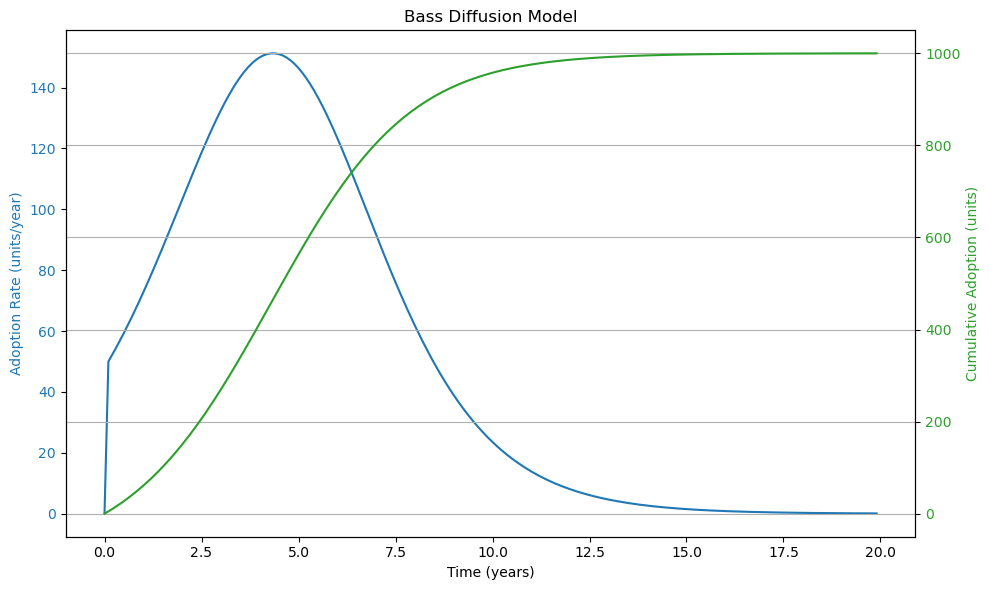

In [139]:
def bass_diffusion_curve(p, q, m, t_max=20, dt=0.1):
    """
    Plots Bass diffusion adoption rate and cumulative adoption over time.

    Parameters:
    p     : innovation coefficient
    q     : imitation coefficient
    m     : total market size
    t_max : simulation duration (years)
    dt    : time step (years)
    """
    time = np.arange(0, t_max, dt)
    A = np.zeros_like(time)  # cumulative adopters
    dA_dt = np.zeros_like(time)  # adoption rate

    for t in range(1, len(time)):
        A_prev = A[t-1]
        dA = (p + q * (A_prev / m)) * (m - A_prev)
        #at every point he adoption curve is above the 50 retired units 
        A[t] = A_prev + dA * dt
        #for chart
        dA_dt[t] = dA

    # Plotting
    fig, ax1 = plt.subplots(figsize=(10, 6))

    ax1.plot(time, dA_dt, label="Adoption Rate", color='tab:blue')
    ax1.set_xlabel("Time (years)")
    ax1.set_ylabel("Adoption Rate (units/year)", color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.plot(time, A, label="Cumulative Adoption", color='tab:green')
    ax2.set_ylabel("Cumulative Adoption (units)", color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    plt.title("Bass Diffusion Model")
    fig.tight_layout()
    plt.grid(True)
    plt.show()

# usage
bass_diffusion_curve(p=par["p"], q=par["q"], m=1000)
